In [3]:
pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/d9/28/3be76b591a2e14a031b681b8283acf1dec2ad521f6f1701b7957df68c466/lightgbm-4.5.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.4 MB 281.8 kB/s eta 0:00:05
   - -------------------------------------- 0.1/1.4 MB 365.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.4 MB 365.7 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.4 MB 409.6 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.4 MB 473.7 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.4 MB 459.5 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.4 MB 518.8 kB/s eta 0:00:03
   ------ ------------------------------


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

import numpy as np

# Load your dataset
data = pd.read_csv(r'C:\Users\user\PycharmProjects\DAE\Data\heart_statlog_cleveland_hungary_final.csv', index_col=0)

# Split the data into features and target
y = data['target']
X = data.drop(columns=['target'])

lgb_data = lgb.Dataset(X, label=y)

# split into train valid and test
X_TRAIN, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_train, test_size=0.25,
                                                  stratify=y_train)  # 0.25 x 0.8 = 0.2

# Checking columns types based on train and valid data so we can catch most of the values
bool_columns = [col for col in X_TRAIN.columns if X_TRAIN[col].nunique() == 2]
real_positive_columns = [col for col in X_TRAIN.columns if X_TRAIN[col].nunique() > 20 and (X_TRAIN[col] > 0).all()]
real_columns = [col for col in X_TRAIN.columns if X_TRAIN[col].nunique() > 20 and not (X_TRAIN[col] > 0).all()]
non_categorical_columns = bool_columns + real_columns + real_positive_columns
# where the categorical has at least 2 unique values and maximum 20
categorical_columns = [col for col in X_train.columns if col not in non_categorical_columns]

scaler_pipeline = ColumnTransformer(
    transformers=[
        ('minmax_scaler', MinMaxScaler(), real_positive_columns),
        ('standard_scaler', StandardScaler(), real_columns),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='passthrough'  # Keep the rest of the columns (like boolean) as is
)

# Fit and transform the training data, and transform the validation and test data
X_train_transformed = scaler_pipeline.fit_transform(X_train)
X_val_transformed = scaler_pipeline.transform(X_val)
X_test_transformed = scaler_pipeline.transform(X_test)

# Get the correct feature names after transformations
feature_names = scaler_pipeline.get_feature_names_out()

# Create DataFrames with the correct column names
X_train = pd.DataFrame(X_train_transformed, columns=feature_names)
X_val = pd.DataFrame(X_val_transformed, columns=feature_names)
X_test = pd.DataFrame(X_test_transformed, columns=feature_names)

# Ensure that all sets have the same columns after one-hot encoding
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Define parameters for LightGBM
params = {
    'objective': 'binary',  # Binary classification
    'metric': 'auc',  # AUC as the evaluation metric
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation using LightGBM
cv_scores = []
for train_index, val_index in kf.split(X_train):
    # Rename the split data inside the loop to avoid overwriting the original data
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    lgb_train = lgb.Dataset(X_train_fold, label=y_train_fold)
    lgb_val = lgb.Dataset(X_val_fold, label=y_val_fold)

    # Train the model
    model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_val], callbacks=[
        lgb.early_stopping(stopping_rounds=50)
    ])

    # Predict and calculate AUC
    y_pred = model.predict(X_val_fold)
    auc = roc_auc_score(y_val_fold, y_pred)
    cv_scores.append(auc)

# Print the AUC scores from cross-validation
print(f'Cross-Validation AUC scores: {cv_scores}')
print(f'Mean AUC: {np.mean(cv_scores)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 300, number of negative: 271
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 295
[LightGBM] [Info] Number of data points in the train set: 571, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525394 -> initscore=0.101664
[LightGBM] [Info] Start training from score 0.101664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [58]:
new_data_with_nans = data.copy()
y= new_data_with_nans['target']
X = new_data_with_nans.drop(columns=['target'])

# Get the total number of columns
n_columns = len(X.columns)

# Split columns into 1/3, 1/2, and the remaining
cols_no_nan = X.columns[:n_columns // 4]  # 1/3 no NaN
cols_nan_20 = X.columns[n_columns // 4: (n_columns // 4) + (n_columns // 2)]  # 1/2 with 20% NaN
cols_nan_70 = X.columns[(n_columns // 4) + (n_columns // 2):]  # The rest with 70% NaN

# Introduce NaNs for columns with a 20% NaN rate
for col in cols_nan_20:
    n_nans = int(0.2 * len(X))  # 20% NaNs
    nan_indices = np.random.choice(X.index, size=n_nans, replace=False)
    X.loc[nan_indices, col] = np.nan

# Introduce NaNs for columns with a 70% NaN rate
for col in cols_nan_70:
    n_nans = int(0.4 * len(X))  # 70% NaNs
    nan_indices = np.random.choice(X.index, size=n_nans, replace=False)
    X.loc[nan_indices, col] = np.nan
    
# COMBINE X AND Y
new_data_with_nans = pd.concat([X, y], axis=1)

In [59]:
new_data_with_nans.to_csv("see.csv")

In [57]:
new_data_with_nans.isna()

,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
age,,,,,,,,,,,
40,False,False,True,True,True,True,True,True,True,True,False
49,False,False,True,True,True,True,True,True,True,True,False
37,False,False,True,True,False,True,True,True,True,True,False
48,False,False,True,True,True,True,True,True,True,True,False
54,False,False,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
45,False,False,True,True,True,True,True,True,True,True,False
68,False,False,True,True,True,True,True,True,True,True,False
57,False,False,True,True,True,True,True,True,True,True,False


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.844618


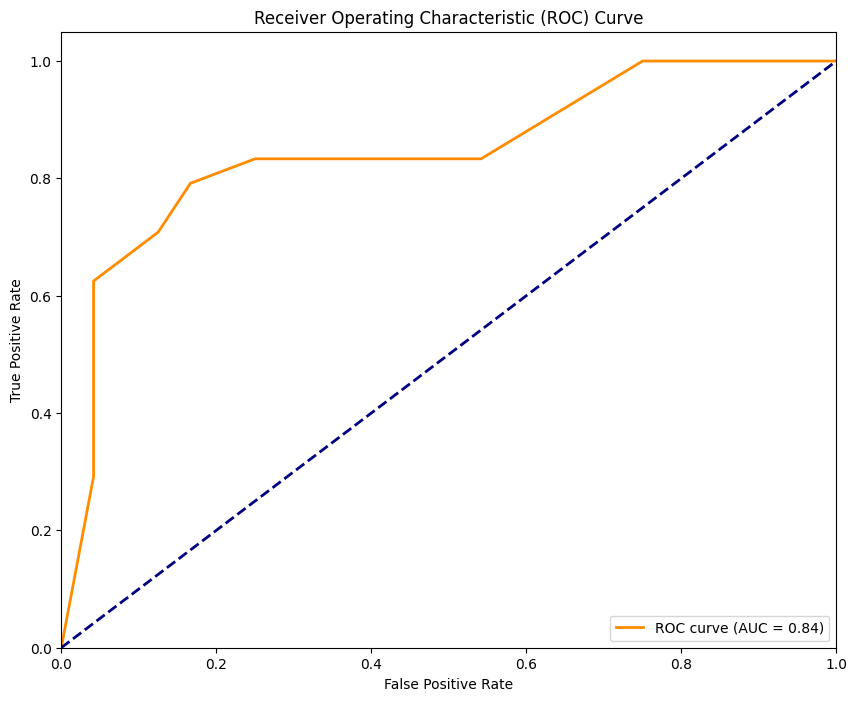

AUC: 0.8446
Feature importance ranking:
1. onehot__resting_bp_s_143.0 (3.000000)
2. onehot__chest_pain_type_4 (3.000000)
3. minmax_scaler__age (2.000000)
4. onehot__resting_bp_s_125.0 (2.000000)
5. onehot__resting_ecg_0.0 (2.000000)
6. standard_scaler__cholesterol (1.000000)
7. onehot__chest_pain_type_1 (1.000000)
8. onehot__resting_bp_s_nan (1.000000)
9. onehot__fasting_blood_sugar_1.0 (0.000000)
10. onehot__fasting_blood_sugar_0.0 (0.000000)
11. onehot__resting_bp_s_160.0 (0.000000)
12. onehot__resting_bp_s_155.0 (0.000000)
13. onehot__resting_bp_s_145.0 (0.000000)
14. onehot__resting_bp_s_136.0 (0.000000)
15. onehot__resting_bp_s_140.0 (0.000000)
16. onehot__resting_bp_s_138.0 (0.000000)
17. onehot__resting_bp_s_130.0 (0.000000)
18. onehot__resting_bp_s_120.0 (0.000000)
19. onehot__resting_bp_s_100.0 (0.000000)
20. onehot__chest_pain_type_3 (0.000000)
21. onehot__chest_pain_type_2 (0.000000)
22. onehot__fasting_blood_sugar_nan (0.000000)
23. remainder__sex (0.000000)
24. onehot__ST_

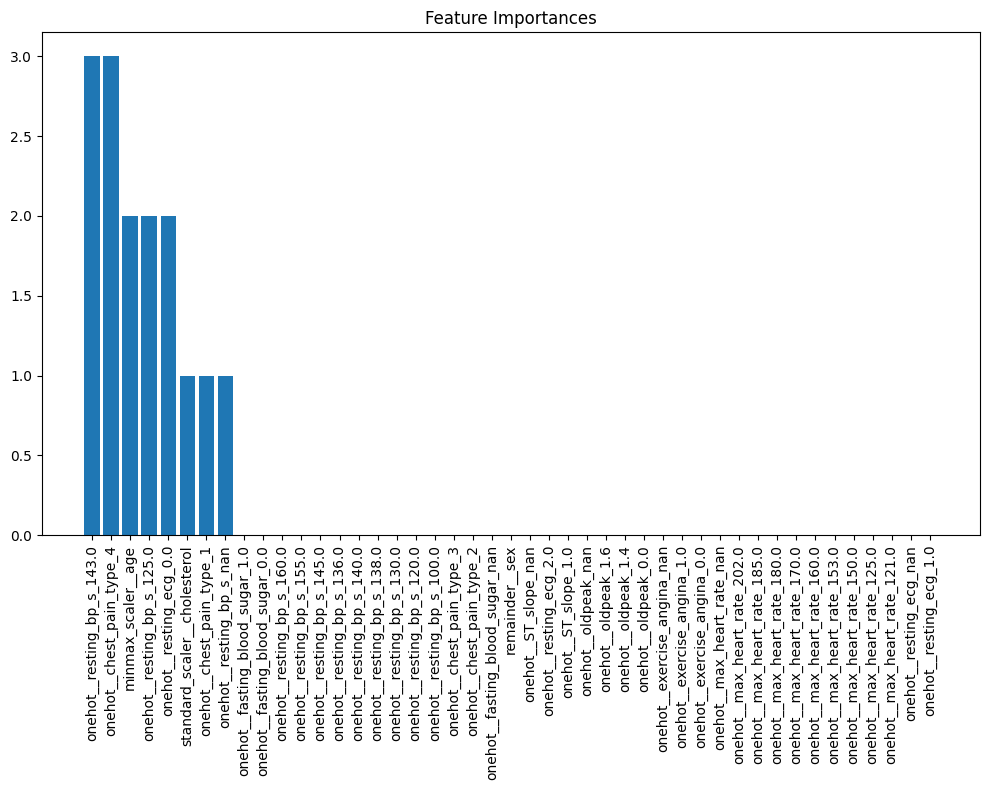

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

data = pd.read_csv('reconstructed.csv', index_col=0)
# y= data['target']
# X = data.drop(columns=['target'])
X = data
y = pd.read_csv('y_test.csv', index_col=0)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

print(f"AUC: {roc_auc:.4f}")

# Feature importance
feature_importance = model.feature_importance()
feature_names = model.feature_name()

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print feature ranking
print("Feature importance ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), feature_importance[indices])
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

In [21]:
# LIGHTGBM

import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve

# Number of runs
n_runs = 10

# Lists to store metrics for each run
val_recall_list = []
val_precision_list = []
val_auc_list = []

test_recall_list = []
test_precision_list = []
test_auc_list = []

data = pd.read_csv('reconstructed.csv', index_col=0)
X = data
y = pd.read_csv('y_test.csv', index_col=0).squeeze()  # Ensure y is a Series

for run in range(n_runs):
    print(f"\n=== Run {run + 1} ===")

    # Split the data into train and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run)

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=run)

    # Arrays to store out-of-fold predictions and true labels
    oof_preds = np.zeros(len(y_train_full))
    oof_true = np.zeros(len(y_train_full))

    # Arrays to store test predictions
    test_preds = np.zeros(len(X_test))

    # Lists to store fold metrics
    fold_val_recall = []
    fold_val_precision = []
    fold_val_auc = []

    fold_test_recall = []
    fold_test_precision = []
    fold_test_auc = []

    # For ROC curve plotting per fold
    plt.figure(figsize=(10, 8))
    plt.title(f'ROC Curves for Each Fold in Run {run + 1}')

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n--- Fold {fold + 1} ---")
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'verbosity': -1,
            'seed': run
        }

        # Train the model with early stopping
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[train_data, val_data],
            valid_names=['train', 'valid'],
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )
        feature_importances = model.feature_importance()

        # Identify zero-importance features
        zero_importance_features = [feature for feature, importance in zip(X_train_full.columns, feature_importances) if importance == 0]
        
        print(f"Number of features with zero importance: {len(zero_importance_features)}")
        print("Zero-importance features:", zero_importance_features)
        # Predict on validation set
        y_val_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

        # Store out-of-fold predictions and true labels
        oof_preds[val_idx] = y_val_pred_proba
        oof_true[val_idx] = y_val

        # Predict on test set
        y_test_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
        y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

        # Aggregate test predictions
        test_preds += y_test_pred_proba / skf.n_splits

        # Calculate metrics for the current fold
        val_recall = recall_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)

        fold_val_recall.append(val_recall)
        fold_val_precision.append(val_precision)
        fold_val_auc.append(val_auc)

        test_recall = recall_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)

        fold_test_recall.append(test_recall)
        fold_test_precision.append(test_precision)
        fold_test_auc.append(test_auc)

        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Test AUC: {test_auc:.4f}')

        # Compute ROC curve for this fold
        fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

        # Plot ROC curve for this fold
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold + 1} (AUC = {val_auc:.4f})')

    # Plot settings for folds
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # Save the plot for folds in this run
    plt.savefig(f'roc_curves_folds_run_{run + 1}.png')
    plt.close()

    # Compute overall metrics on out-of-fold predictions
    oof_auc = roc_auc_score(oof_true, oof_preds)
    oof_recall = recall_score(oof_true, (oof_preds >= 0.5).astype(int))
    oof_precision = precision_score(oof_true, (oof_preds >= 0.5).astype(int))

    val_recall_list.append(oof_recall)
    val_precision_list.append(oof_precision)
    val_auc_list.append(oof_auc)

    # Compute test metrics using averaged predictions
    test_auc = roc_auc_score(y_test, test_preds)
    test_recall = recall_score(y_test, (test_preds >= 0.5).astype(int))
    test_precision = precision_score(y_test, (test_preds >= 0.5).astype(int))

    test_recall_list.append(test_recall)
    test_precision_list.append(test_precision)
    test_auc_list.append(test_auc)

    print('\nAggregated Validation Metrics:')
    print(f'Recall: {oof_recall:.4f}')
    print(f'Precision: {oof_precision:.4f}')
    print(f'AUC: {oof_auc:.4f}')

    print('\nAggregated Test Metrics:')
    print(f'Recall: {test_recall:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'AUC: {test_auc:.4f}')

    # Plot combined ROC curve using out-of-fold predictions
    fpr, tpr, thresholds = roc_curve(oof_true, oof_preds)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'Combined ROC Curve (AUC = {oof_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'Combined ROC Curve for Run {run + 1}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # Save the combined ROC curve plot for this run
    plt.savefig(f'combined_roc_curve_run_{run + 1}.png')
    plt.close()

# Calculate mean and standard deviation of the metrics across runs
val_recall_mean = np.mean(val_recall_list)
val_recall_std = np.std(val_recall_list)
val_precision_mean = np.mean(val_precision_list)
val_precision_std = np.std(val_precision_list)
val_auc_mean = np.mean(val_auc_list)
val_auc_std = np.std(val_auc_list)

test_recall_mean = np.mean(test_recall_list)
test_recall_std = np.std(test_recall_list)
test_precision_mean = np.mean(test_precision_list)
test_precision_std = np.std(test_precision_list)
test_auc_mean = np.mean(test_auc_list)
test_auc_std = np.std(test_auc_list)

print('\n=== Summary of Validation Metrics Across Runs ===')
print(f'Recall: Mean = {val_recall_mean:.4f}, Std = {val_recall_std:.4f}')
print(f'Precision: Mean = {val_precision_mean:.4f}, Std = {val_precision_std:.4f}')
print(f'AUC: Mean = {val_auc_mean:.4f}, Std = {val_auc_std:.4f}')

print('\n=== Summary of Test Metrics Across Runs ===')
print(f'Recall: Mean = {test_recall_mean:.4f}, Std = {test_recall_std:.4f}')
print(f'Precision: Mean = {test_precision_mean:.4f}, Std = {test_precision_std:.4f}')
print(f'AUC: Mean = {test_auc_mean:.4f}, Std = {test_auc_std:.4f}')



=== Run 1 ===

--- Fold 1 ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.861806	valid's auc: 0.87395
Number of features with zero importance: 11
Zero-importance features: ['onehot__chest pain type_3', 'onehot__resting bp s_143.0', 'onehot__resting bp s_145.0', 'onehot__resting bp s_160.0', 'onehot__fasting blood sugar_1.0', 'onehot__resting ecg_0.0', 'onehot__resting ecg_2.0', 'onehot__max heart rate_180.0', 'onehot__max heart rate_185.0', 'onehot__oldpeak_0.0', 'remainder__sex']
Validation AUC: 0.8739
Test AUC: 0.8652

--- Fold 2 ---
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.870023	valid's auc: 0.770833
Number of features with zero importance: 15
Zero-importance features: ['onehot__chest pain type_3', 'onehot__resting bp s_140.0', 'onehot__resting bp s_143.0', 'onehot__resting bp s_160.0', 'onehot__fasting blood sugar_1.0', 'onehot__restin

In [19]:
# LOGISTIC REGRESSION

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

# Number of runs
n_runs = 10

# Lists to store metrics for each run
val_recall_list = []
val_precision_list = []
val_auc_list = []

test_recall_list = []
test_precision_list = []
test_auc_list = []

data = pd.read_csv('reconstructed.csv', index_col=0)
X = data
y = pd.read_csv('y_test.csv', index_col=0).squeeze()  # Ensure y is a Series

for run in range(n_runs):
    print(f"\n=== Run {run + 1} ===")

    # Split the data into train and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y)

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    # Arrays to store out-of-fold predictions and true labels
    oof_preds = np.zeros(len(y_train_full))
    oof_true = y_train_full.values  # Convert to numpy array if needed

    # Arrays to store test predictions
    test_preds = np.zeros(len(X_test))

    # Lists to store fold metrics
    fold_val_recall = []
    fold_val_precision = []
    fold_val_auc = []

    fold_test_recall = []
    fold_test_precision = []
    fold_test_auc = []

    # For ROC curve plotting per fold
    plt.figure(figsize=(10, 8))
    plt.title(f'ROC Curves for Each Fold in Run {run + 1}')

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n--- Fold {fold + 1} ---")
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        # Initialize Logistic Regression model
        model = LogisticRegression(
            max_iter=1000  # Increase if the model doesn't converge
        )

        # Train the model
        model.fit(X_train, y_train)
                  
        # Get coefficients
        coefficients = model.coef_[0]
        
        # Identify zero-importance features
        zero_importance_features_logreg = [feature for feature, coef in zip(X_train_full.columns, coefficients) if coef == 0]
        
        print(f"Number of features with zero coefficients: {len(zero_importance_features_logreg)}")
        print("Zero-coefficient features:", zero_importance_features_logreg)
        
        # Predict probabilities on validation set
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = model.predict(X_val)

        # Store out-of-fold predictions and true labels
        oof_preds[val_idx] = y_val_pred_proba

        # Predict probabilities on test set
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
        y_test_pred = model.predict(X_test)

        # Aggregate test predictions
        test_preds += y_test_pred_proba / skf.n_splits

        # Calculate metrics for the current fold
        val_recall = recall_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)

        fold_val_recall.append(val_recall)
        fold_val_precision.append(val_precision)
        fold_val_auc.append(val_auc)

        test_recall = recall_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)

        fold_test_recall.append(test_recall)
        fold_test_precision.append(test_precision)
        fold_test_auc.append(test_auc)

        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Test AUC: {test_auc:.4f}')

        # Compute ROC curve for this fold
        fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

        # Plot ROC curve for this fold
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold + 1} (AUC = {val_auc:.4f})')

    # Plot settings for folds
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # Save the plot for folds in this run
    plt.savefig(f'roc_curves_folds_run_{run + 1}_logreg.png')
    plt.close()

    # Compute overall metrics on out-of-fold predictions
    oof_auc = roc_auc_score(oof_true, oof_preds)
    oof_recall = recall_score(oof_true, (oof_preds >= 0.5).astype(int))
    oof_precision = precision_score(oof_true, (oof_preds >= 0.5).astype(int))

    val_recall_list.append(oof_recall)
    val_precision_list.append(oof_precision)
    val_auc_list.append(oof_auc)

    # Compute test metrics using averaged predictions
    test_auc = roc_auc_score(y_test, test_preds)
    test_recall = recall_score(y_test, (test_preds >= 0.5).astype(int))
    test_precision = precision_score(y_test, (test_preds >= 0.5).astype(int))

    test_recall_list.append(test_recall)
    test_precision_list.append(test_precision)
    test_auc_list.append(test_auc)

    print('\nAggregated Validation Metrics:')
    print(f'Recall: {oof_recall:.4f}')
    print(f'Precision: {oof_precision:.4f}')
    print(f'AUC: {oof_auc:.4f}')

    print('\nAggregated Test Metrics:')
    print(f'Recall: {test_recall:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'AUC: {test_auc:.4f}')

    # Plot combined ROC curve using out-of-fold predictions
    fpr, tpr, thresholds = roc_curve(oof_true, oof_preds)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'Combined ROC Curve (AUC = {oof_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'Combined ROC Curve for Run {run + 1}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # Save the combined ROC curve plot for this run
    plt.savefig(f'combined_roc_curve_run_{run + 1}_logreg.png')
    plt.close()

# Calculate mean and standard deviation of the metrics across runs
val_recall_mean = np.mean(val_recall_list)
val_recall_std = np.std(val_recall_list)
val_precision_mean = np.mean(val_precision_list)
val_precision_std = np.std(val_precision_list)
val_auc_mean = np.mean(val_auc_list)
val_auc_std = np.std(val_auc_list)

test_recall_mean = np.mean(test_recall_list)
test_recall_std = np.std(test_recall_list)
test_precision_mean = np.mean(test_precision_list)
test_precision_std = np.std(test_precision_list)
test_auc_mean = np.mean(test_auc_list)
test_auc_std = np.std(test_auc_list)

print('\n=== Summary of Validation Metrics Across Runs ===')
print(f'Recall: Mean = {val_recall_mean:.4f}, Std = {val_recall_std:.4f}')
print(f'Precision: Mean = {val_precision_mean:.4f}, Std = {val_precision_std:.4f}')
print(f'AUC: Mean = {val_auc_mean:.4f}, Std = {val_auc_std:.4f}')

print('\n=== Summary of Test Metrics Across Runs ===')
print(f'Recall: Mean = {test_recall_mean:.4f}, Std = {test_recall_std:.4f}')
print(f'Precision: Mean = {test_precision_mean:.4f}, Std = {test_precision_std:.4f}')
print(f'AUC: Mean = {test_auc_mean:.4f}, Std = {test_auc_std:.4f}')





=== Run 1 ===

--- Fold 1 ---
Validation AUC: 0.9188
Test AUC: 0.7922

--- Fold 2 ---
Validation AUC: 0.8583
Test AUC: 0.7904

--- Fold 3 ---
Validation AUC: 0.7500
Test AUC: 0.7887

--- Fold 4 ---
Validation AUC: 0.8111
Test AUC: 0.7870

--- Fold 5 ---
Validation AUC: 0.7319
Test AUC: 0.7974

Aggregated Validation Metrics:
Recall: 0.7327
Precision: 0.7708
AUC: 0.7536

Aggregated Test Metrics:
Recall: 0.6800
Precision: 0.7391
AUC: 0.7904

=== Run 2 ===

--- Fold 1 ---
Validation AUC: 0.7451
Test AUC: 0.7878

--- Fold 2 ---
Validation AUC: 0.8556
Test AUC: 0.7878

--- Fold 3 ---
Validation AUC: 0.8389
Test AUC: 0.7878

--- Fold 4 ---
Validation AUC: 0.8208
Test AUC: 0.7878

--- Fold 5 ---
Validation AUC: 0.8264
Test AUC: 0.7878

Aggregated Validation Metrics:
Recall: 0.6931
Precision: 0.7778
AUC: 0.7846

Aggregated Test Metrics:
Recall: 0.8400
Precision: 0.7241
AUC: 0.7878

=== Run 3 ===

--- Fold 1 ---
Validation AUC: 0.7717
Test AUC: 0.8548

--- Fold 2 ---
Validation AUC: 0.7944
Test

In [84]:
# gcn_model_with_metrics.py
#pip install torch torchvision torchaudio pytorch-lightning torch-geometric sklearn pandas numpy matplotlib



import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import pandas as pd
import numpy as np

# Set random seed for reproducibility
pl.seed_everything(42)

# Step 1: Load your data

# 1.1 Load the edge list with weights
edge_list_df = pd.read_csv('edges.csv', header=None)
edge_list_df.columns = ['source', 'target', 'weight']

# Map node IDs to consecutive integers starting from 0
unique_nodes = pd.unique(edge_list_df[['source', 'target']].values.ravel())
node_id_mapping = {node_id: idx for idx, node_id in enumerate(unique_nodes)}
edge_list_df['source'] = edge_list_df['source'].map(node_id_mapping)
edge_list_df['target'] = edge_list_df['target'].map(node_id_mapping)

# Edge index tensor
edge_index = torch.tensor(
    [edge_list_df['source'].values, edge_list_df['target'].values],
    dtype=torch.long
)

# Edge weight tensor
edge_weight = torch.tensor(edge_list_df['weight'].values, dtype=torch.float)

# Make the graph undirected by adding reverse edges
edge_index_rev = edge_index[[1, 0], :]  # Swap source and target
edge_index = torch.cat([edge_index, edge_index_rev], dim=1)
edge_weight = torch.cat([edge_weight, edge_weight], dim=0)

# 1.2 Load the feature matrix and separate labels
features_df = pd.read_csv('features.csv', header=None)

# Adjust the label_column_index based on where the label is in your feature matrix
label_column_index = -1  # Change if the label is not the last column

# Extract labels
labels = features_df.iloc[:, label_column_index]

# Remove the label column from the feature matrix
features_df = features_df.drop(features_df.columns[label_column_index], axis=1)

# Map node IDs in the feature matrix
features_df['node_id'] = features_df.index.map(lambda idx: node_id_mapping.get(idx, idx))
features_df.sort_values('node_id', inplace=True)
features_df = features_df.drop('node_id', axis=1)
features_df.reset_index(drop=True, inplace=True)

# Convert features to tensor
x = torch.tensor(features_df.values, dtype=torch.float)

# Convert labels to tensor
labels = labels.reset_index(drop=True)
y = torch.tensor(labels.values, dtype=torch.long)

# Step 2: Create the Data object
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight, y=y)

# Step 3: Split your data
num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_ratio = 0.8
val_ratio = 0.1

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Step 4: Define the GCN model
class WeightedGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(WeightedGCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        # Add self-loops to the adjacency matrix
        edge_index, edge_weight = add_self_loops(
            edge_index, edge_weight=edge_weight, fill_value=1, num_nodes=x.size(0)
        )

        # Compute normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

        # Linear transformation
        x = self.lin(x)

        # Start propagating messages
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        return norm.view(-1, 1) * x_j

class GCNModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, hidden_channels=16):
        super(GCNModel, self).__init__()
        self.conv1 = WeightedGCNConv(num_features, hidden_channels)
        self.conv2 = WeightedGCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight

        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        return x

    def training_step(self, batch, batch_idx):
        out = self(batch)
        # Get the logits for training nodes
        train_logits = out[batch.train_mask]
        train_labels = batch.y[batch.train_mask]

        # Compute loss
        loss = F.cross_entropy(train_logits, train_labels)

        # Optionally compute accuracy
        acc = self.compute_accuracy(train_logits, train_labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        out = self(batch)
        val_logits = out[batch.val_mask]
        val_labels = batch.y[batch.val_mask]

        val_probs = F.softmax(val_logits, dim=1)
        val_preds = val_probs.argmax(dim=1)

        loss = F.cross_entropy(val_logits, val_labels)
        precision = precision_score(val_labels.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        recall = recall_score(val_labels.cpu(), val_preds.cpu(), average='weighted', zero_division=0)

        try:
            auc = roc_auc_score(val_labels.cpu(), val_probs.cpu(), multi_class='ovr', average='weighted')
        except ValueError:
            auc = float('nan')

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_auc', auc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        out = self(batch)
        test_logits = out[batch.test_mask]
        test_labels = batch.y[batch.test_mask]

        test_probs = F.softmax(test_logits, dim=1)
        test_preds = test_probs.argmax(dim=1)

        loss = F.cross_entropy(test_logits, test_labels)
        precision = precision_score(test_labels.cpu(), test_preds.cpu(), average='weighted', zero_division=0)
        recall = recall_score(test_labels.cpu(), test_preds.cpu(), average='weighted', zero_division=0)

        try:
            auc = roc_auc_score(test_labels.cpu(), test_probs.cpu(), multi_class='ovr', average='weighted')
        except ValueError:
            auc = float('nan')

        self.log('test_loss', loss)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        self.log('test_auc', auc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        return optimizer

    @staticmethod
    def compute_accuracy(logits, labels):
        preds = logits.argmax(dim=1)
        correct = preds.eq(labels).sum().item()
        acc = correct / len(labels)
        return acc

# Step 5: Prepare the DataLoader
dataset = [data]
loader = DataLoader(dataset, batch_size=1)

# Step 6: Instantiate and train the model
num_classes = y.max().item() + 1

model = GCNModel(
    num_features=data.num_node_features,
    num_classes=num_classes,
    hidden_channels=16
)

trainer = pl.Trainer(
    max_epochs=100,
    progress_bar_refresh_rate=20,
    logger=True,
    checkpoint_callback=False
)

trainer.fit(model, loader, loader)

# Step 7: Evaluate the model
trainer.test(model, dataloaders=loader)

# Step 8: Optionally, plot ROC curves after testing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, data, num_classes):
    model.eval()
    data = data.to(model.device)
    with torch.no_grad():
        out = model(data)
        test_logits = out[data.test_mask]
        test_labels = data.y[data.test_mask]
        test_probs = F.softmax(test_logits, dim=1).cpu().numpy()
        test_labels = test_labels.cpu().numpy()

    # Binarize the labels
    test_labels_binarized = label_binarize(test_labels, classes=range(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to plot ROC curves
plot_roc_curve(model, data, num_classes)


RuntimeError: all elements of input should be between 0 and 1

In [ ]:
# no weights
# gcn_model_no_edge_weights.py

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import pandas as pd
import numpy as np

# Set random seed for reproducibility
pl.seed_everything(42)

# Step 1: Load your data

# 1.1 Load the edge list without weights
edge_list_df = pd.read_csv('edges.csv', header=None)
edge_list_df.columns = ['source', 'target']

# Map node IDs to consecutive integers starting from 0
unique_nodes = pd.unique(edge_list_df[['source', 'target']].values.ravel())
node_id_mapping = {node_id: idx for idx, node_id in enumerate(unique_nodes)}
edge_list_df['source'] = edge_list_df['source'].map(node_id_mapping)
edge_list_df['target'] = edge_list_df['target'].map(node_id_mapping)

# Edge index tensor
edge_index = torch.tensor(
    [edge_list_df['source'].values, edge_list_df['target'].values],
    dtype=torch.long
)

# Make the graph undirected by adding reverse edges
edge_index_rev = edge_index[[1, 0], :]  # Swap source and target
edge_index = torch.cat([edge_index, edge_index_rev], dim=1)

# 1.2 Load the feature matrix and separate labels
features_df = pd.read_csv('features.csv', header=None)

# Adjust the label_column_index based on where the label is in your feature matrix
label_column_index = -1  # Change if the label is not the last column

# Extract labels
labels = features_df.iloc[:, label_column_index]

# Remove the label column from the feature matrix
features_df = features_df.drop(features_df.columns[label_column_index], axis=1)

# Map node IDs in the feature matrix
features_df['node_id'] = features_df.index.map(lambda idx: node_id_mapping.get(idx, idx))
features_df.sort_values('node_id', inplace=True)
features_df = features_df.drop('node_id', axis=1)
features_df.reset_index(drop=True, inplace=True)

# Convert features to tensor
x = torch.tensor(features_df.values, dtype=torch.float)

# Convert labels to tensor
labels = labels.reset_index(drop=True)
y = torch.tensor(labels.values, dtype=torch.long)

# Step 2: Create the Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Step 3: Split your data
num_nodes = data.num_nodes
indices = np.random.permutation(num_nodes)
train_ratio = 0.8
val_ratio = 0.1

train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Step 4: Define the GCN model without edge weights
class GCNModel(pl.LightningModule):
    def __init__(self, num_features, num_classes, hidden_channels=16):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

    def training_step(self, batch, batch_idx):
        out = self(batch)
        # Get the logits for training nodes
        train_logits = out[batch.train_mask]
        train_labels = batch.y[batch.train_mask]

        # Compute loss
        loss = F.cross_entropy(train_logits, train_labels)

        # Optionally compute accuracy
        acc = self.compute_accuracy(train_logits, train_labels)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        out = self(batch)
        val_logits = out[batch.val_mask]
        val_labels = batch.y[batch.val_mask]

        val_probs = F.softmax(val_logits, dim=1)
        val_preds = val_probs.argmax(dim=1)

        loss = F.cross_entropy(val_logits, val_labels)
        precision = precision_score(val_labels.cpu(), val_preds.cpu(), average='weighted', zero_division=0)
        recall = recall_score(val_labels.cpu(), val_preds.cpu(), average='weighted', zero_division=0)

        try:
            auc = roc_auc_score(val_labels.cpu(), val_probs.cpu(), multi_class='ovr', average='weighted')
        except ValueError:
            auc = float('nan')

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_precision', precision, prog_bar=True)
        self.log('val_recall', recall, prog_bar=True)
        self.log('val_auc', auc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        out = self(batch)
        test_logits = out[batch.test_mask]
        test_labels = batch.y[batch.test_mask]

        test_probs = F.softmax(test_logits, dim=1)
        test_preds = test_probs.argmax(dim=1)

        loss = F.cross_entropy(test_logits, test_labels)
        precision = precision_score(test_labels.cpu(), test_preds.cpu(), average='weighted', zero_division=0)
        recall = recall_score(test_labels.cpu(), test_preds.cpu(), average='weighted', zero_division=0)

        try:
            auc = roc_auc_score(test_labels.cpu(), test_probs.cpu(), multi_class='ovr', average='weighted')
        except ValueError:
            auc = float('nan')

        self.log('test_loss', loss)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        self.log('test_auc', auc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        return optimizer

    @staticmethod
    def compute_accuracy(logits, labels):
        preds = logits.argmax(dim=1)
        correct = preds.eq(labels).sum().item()
        acc = correct / len(labels)
        return acc

# Step 5: Prepare the DataLoader
dataset = [data]
loader = DataLoader(dataset, batch_size=1)

# Step 6: Instantiate and train the model
num_classes = y.max().item() + 1

model = GCNModel(
    num_features=data.num_node_features,
    num_classes=num_classes,
    hidden_channels=16
)

trainer = pl.Trainer(
    max_epochs=100,
    progress_bar_refresh_rate=20,
    logger=True,
    checkpoint_callback=False
)

trainer.fit(model, loader, loader)

# Step 7: Evaluate the model
trainer.test(model, dataloaders=loader)

# Step 8: Optionally, plot ROC curves after testing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, data, num_classes):
    model.eval()
    data = data.to(model.device)
    with torch.no_grad():
        out = model(data)
        test_logits = out[data.test_mask]
        test_labels = data.y[data.test_mask]
        test_probs = F.softmax(test_logits, dim=1).cpu().numpy()
        test_labels = test_labels.cpu().numpy()

    # Binarize the labels
    test_labels_binarized = label_binarize(test_labels, classes=range(num_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to plot ROC curves
plot_roc_curve(model, data, num_classes)


In [ ]:
# mlp
# MLP Classifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Number of runs
n_runs = 10

# Lists to store metrics for each run
val_recall_list = []
val_precision_list = []
val_auc_list = []

test_recall_list = []
test_precision_list = []
test_auc_list = []

# Load your data
data = pd.read_csv('reconstructed.csv', index_col=0)
X = data
y = pd.read_csv('y_test.csv', index_col=0).squeeze()  # Ensure y is a Series

for run in range(n_runs):
    print(f"\n=== Run {run + 1} ===")

    # Split the data into train and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=run
    )

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=run)

    # Arrays to store out-of-fold predictions and true labels
    oof_preds = np.zeros(len(y_train_full))
    oof_true = y_train_full.values  # Convert to numpy array if needed

    # Arrays to store test predictions
    test_preds = np.zeros(len(X_test))

    # Lists to store fold metrics
    fold_val_recall = []
    fold_val_precision = []
    fold_val_auc = []

    fold_test_recall = []
    fold_test_precision = []
    fold_test_auc = []

    # For ROC curve plotting per fold
    plt.figure(figsize=(10, 8))
    plt.title(f'ROC Curves for Each Fold in Run {run + 1}')

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
        print(f"\n--- Fold {fold + 1} ---")
        X_train, X_val = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_train, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # Initialize MLP Classifier
        model = MLPClassifier(
            hidden_layer_sizes=(100,),  # You can adjust the hidden layer sizes
            activation='relu',
            solver='adam',
            max_iter=200,
            random_state=run
        )

        # Train the model
        model.fit(X_train_scaled, y_train)

        # Predict probabilities on validation set
        y_val_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_val_pred = model.predict(X_val_scaled)

        # Store out-of-fold predictions and true labels
        oof_preds[val_idx] = y_val_pred_proba

        # Predict probabilities on test set
        y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        y_test_pred = model.predict(X_test_scaled)

        # Aggregate test predictions
        test_preds += y_test_pred_proba / skf.n_splits

        # Calculate metrics for the current fold
        val_recall = recall_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_auc = roc_auc_score(y_val, y_val_pred_proba)

        fold_val_recall.append(val_recall)
        fold_val_precision.append(val_precision)
        fold_val_auc.append(val_auc)

        test_recall = recall_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_pred_proba)

        fold_test_recall.append(test_recall)
        fold_test_precision.append(test_precision)
        fold_test_auc.append(test_auc)

        print(f'Validation AUC: {val_auc:.4f}')
        print(f'Test AUC: {test_auc:.4f}')

        # Compute ROC curve for this fold
        fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)

        # Plot ROC curve for this fold
        plt.plot(fpr, tpr, lw=1, label=f'Fold {fold + 1} (AUC = {val_auc:.4f})')

    # Plot settings for folds
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # Save the plot for folds in this run
    plt.savefig(f'roc_curves_folds_run_{run + 1}_mlp.png')
    plt.close()

    # Compute overall metrics on out-of-fold predictions
    oof_auc = roc_auc_score(oof_true, oof_preds)
    oof_recall = recall_score(oof_true, (oof_preds >= 0.5).astype(int))
    oof_precision = precision_score(oof_true, (oof_preds >= 0.5).astype(int))

    val_recall_list.append(oof_recall)
    val_precision_list.append(oof_precision)
    val_auc_list.append(oof_auc)

    # Compute test metrics using averaged predictions
    test_auc = roc_auc_score(y_test, test_preds)
    test_recall = recall_score(y_test, (test_preds >= 0.5).astype(int))
    test_precision = precision_score(y_test, (test_preds >= 0.5).astype(int))

    test_recall_list.append(test_recall)
    test_precision_list.append(test_precision)
    test_auc_list.append(test_auc)

    print('\nAggregated Validation Metrics:')
    print(f'Recall: {oof_recall:.4f}')
    print(f'Precision: {oof_precision:.4f}')
    print(f'AUC: {oof_auc:.4f}')

    print('\nAggregated Test Metrics:')
    print(f'Recall: {test_recall:.4f}')
    print(f'Precision: {test_precision:.4f}')
    print(f'AUC: {test_auc:.4f}')

    # Plot combined ROC curve using out-of-fold predictions
    fpr, tpr, thresholds = roc_curve(oof_true, oof_preds)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'Combined ROC Curve (AUC = {oof_auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'Combined ROC Curve for Run {run + 1}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    # Save the combined ROC curve plot for this run
    plt.savefig(f'combined_roc_curve_run_{run + 1}_mlp.png')
    plt.close()

# Calculate mean and standard deviation of the metrics across runs
val_recall_mean = np.mean(val_recall_list)
val_recall_std = np.std(val_recall_list)
val_precision_mean = np.mean(val_precision_list)
val_precision_std = np.std(val_precision_list)
val_auc_mean = np.mean(val_auc_list)
val_auc_std = np.std(val_auc_list)

test_recall_mean = np.mean(test_recall_list)
test_recall_std = np.std(test_recall_list)
test_precision_mean = np.mean(test_precision_list)
test_precision_std = np.std(test_precision_list)
test_auc_mean = np.mean(test_auc_list)
test_auc_std = np.std(test_auc_list)

print('\n=== Summary of Validation Metrics Across Runs ===')
print(f'Recall: Mean = {val_recall_mean:.4f}, Std = {val_recall_std:.4f}')
print(f'Precision: Mean = {val_precision_mean:.4f}, Std = {val_precision_std:.4f}')
print(f'AUC: Mean = {val_auc_mean:.4f}, Std = {val_auc_std:.4f}')

print('\n=== Summary of Test Metrics Across Runs ===')
print(f'Recall: Mean = {test_recall_mean:.4f}, Std = {test_recall_std:.4f}')
print(f'Precision: Mean = {test_precision_mean:.4f}, Std = {test_precision_std:.4f}')
print(f'AUC: Mean = {test_auc_mean:.4f}, Std = {test_auc_std:.4f}')
